In this file, we show how to use the utility functions to run cross validation based on test sequence, and explore if we could improve the performance by seperating the data based on the operation mode.

In utility.py, we define a function `run_cv_one_motor` to run cross validation for a specified motor.

In this analysis, we use the dataset from motor 6, where we have the following operation modes:
- not moving: '20240425_093699', '20240425_094425', '20240426_140055'
- pickup and place: '20240503_163963', '20240325_155003'
- only moving the motor 6: '20240503_164675', '20240503_165189'
We will train a model for each operation mode, and compare the results by mixing all the operation modes together.

From this notebook, you should:
- Understand how to use the utility functions to run cross validation.
- Have some insights about how to improve the performance of the model:
    - Should we select the features?
    - Should we seperate operation modes?
    - Should we consider the history in the prediciton as well?

In [8]:
from utility import read_all_test_data_from_path
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
%matplotlib inline


# Subfunction for data preprocessing.
def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()


# Ignore warnings.
warnings.filterwarnings('ignore')

# Define the classification model.
# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('mdl', LogisticRegression(class_weight='balanced'))    # Step 2: Linear Regression
]

# Create the pipeline
pipeline = Pipeline(steps)

# Define hyperparameters to search
param_grid = {
    'mdl__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Inverse of regularization strength
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1', cv=5)

# Read all the dataset.
base_dictionary = '../../projects/maintenance_industry_4_2024/dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers, is_plot=False)

# Demo: How to use the utility function for cross validation.

We can use `run_cv_one_motor` to easily run cross validation for one motor. For example, we could run a five-fold cross validation with a logistic regression model using the following code:

Model for predicting the label of motor 6:

 New cv run:

Training performance, accuracy is: 0.8762412206345362
Training performance, precision is: 0.7578796561604585
Training performance, recall: 0.859463850528026
Training performance, F1: 0.805481537875904


Prediction performance, accuracy is: 0.22359436292314397
Prediction performance, precision is: 0.01402553904123927
Prediction performance, recall is：0.09557774607703282
Prediction performance, F1 is：0.024461482292807594


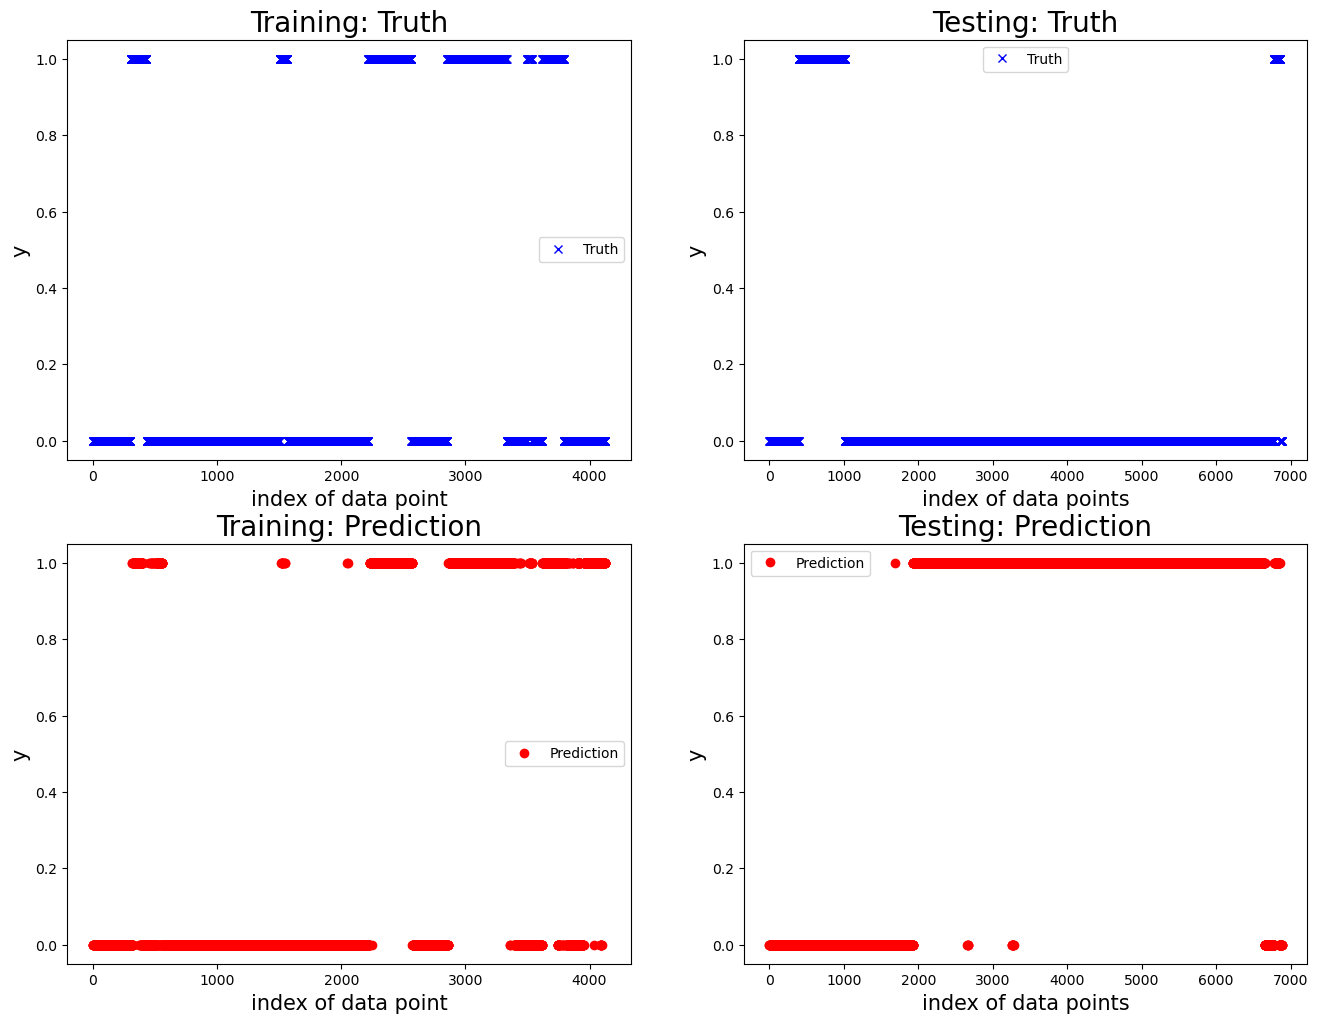


 New cv run:

Training performance, accuracy is: 0.9295280612244898
Training performance, precision is: 0.7398663697104677
Training performance, recall: 0.9545977011494253
Training performance, F1: 0.8336260978670013


Prediction performance, accuracy is: 0.78428927680798
Prediction performance, precision is: 0.0
Prediction performance, recall is：0.0
Prediction performance, F1 is：0.0


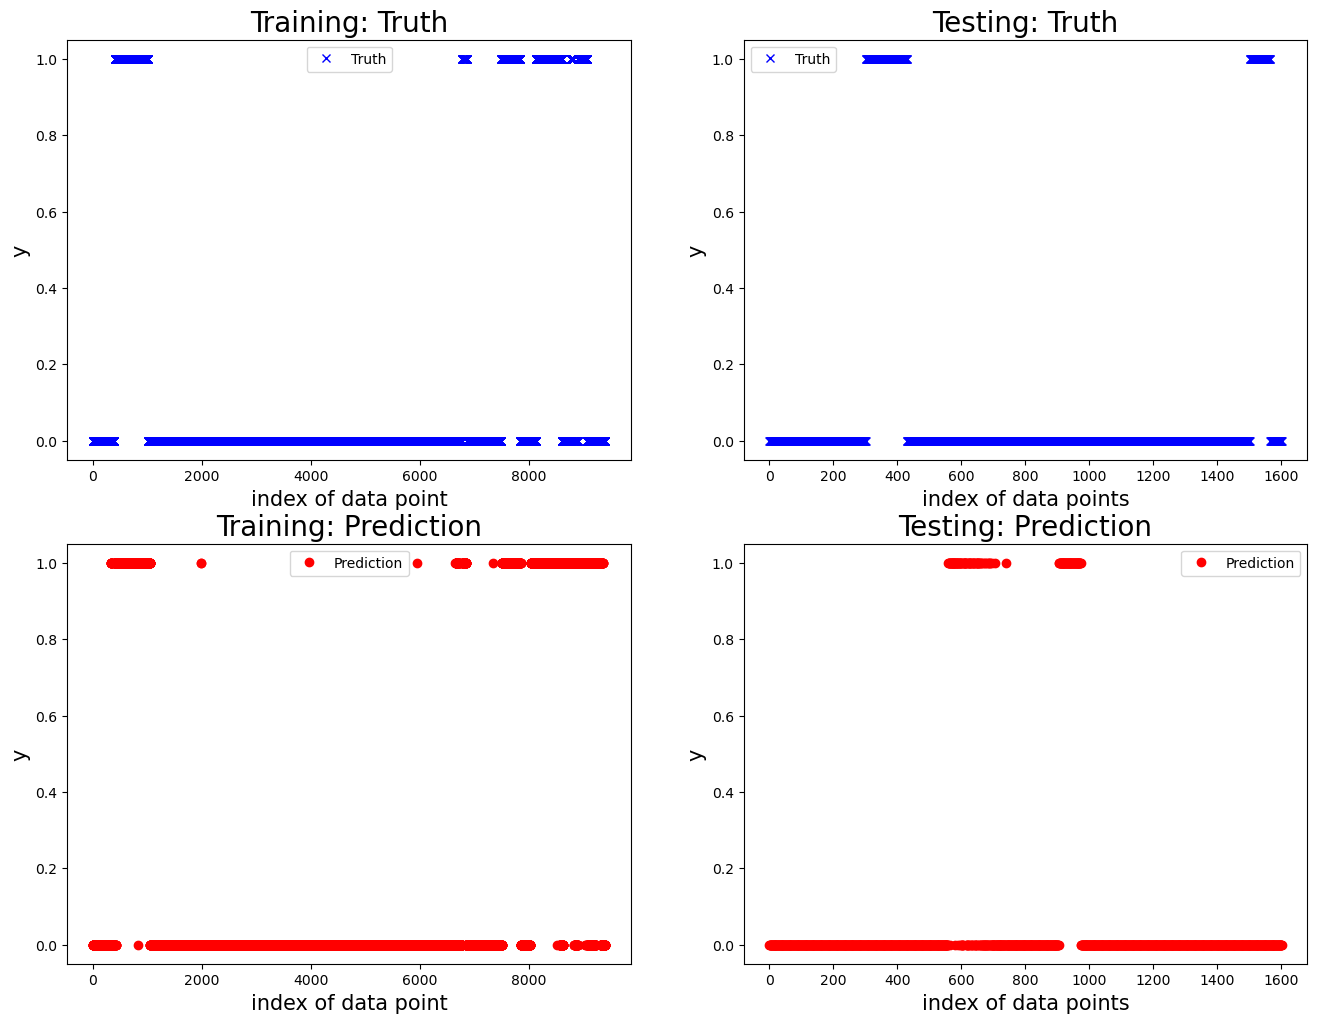


 New cv run:

Training performance, accuracy is: 0.8211497515968772
Training performance, precision is: 0.47216174183514775
Training performance, recall: 0.9577287066246056
Training performance, F1: 0.6325000000000001


Prediction performance, accuracy is: 0.5926892950391645
Prediction performance, precision is: 0.0
Prediction performance, recall is：0.0
Prediction performance, F1 is：0.0


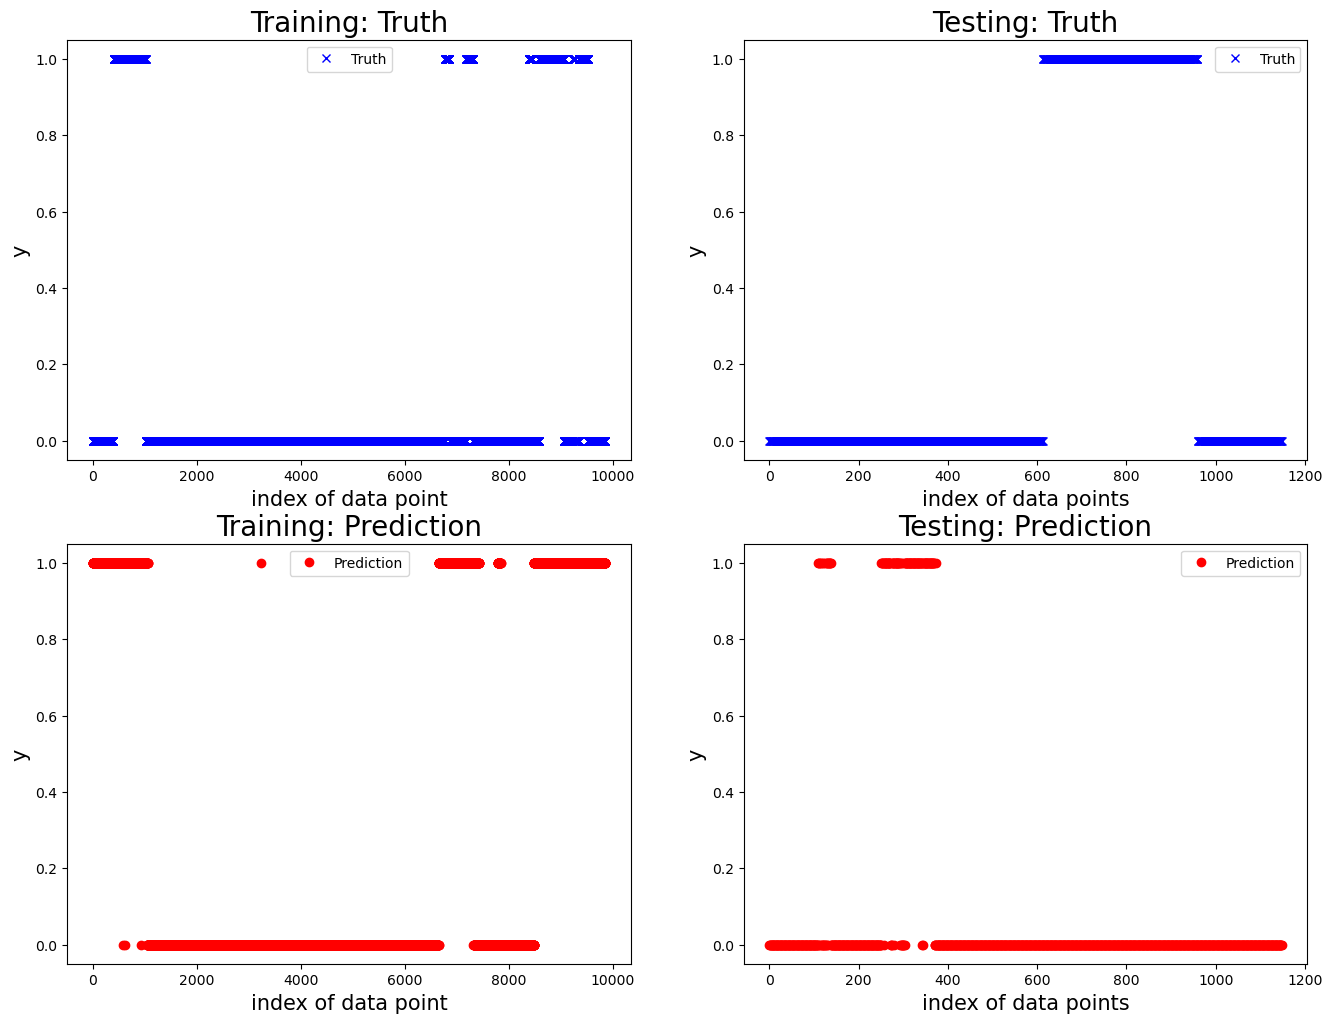


 New cv run:

Training performance, accuracy is: 0.808124459809853
Training performance, precision is: 0.4169202678027998
Training performance, recall: 0.9435261707988981
Training performance, F1: 0.5783030814689742


Prediction performance, accuracy is: 0.9148580968280468
Prediction performance, precision is: 0.9820224719101124
Prediction performance, recall is：0.9104166666666667
Prediction performance, F1 is：0.9448648648648649


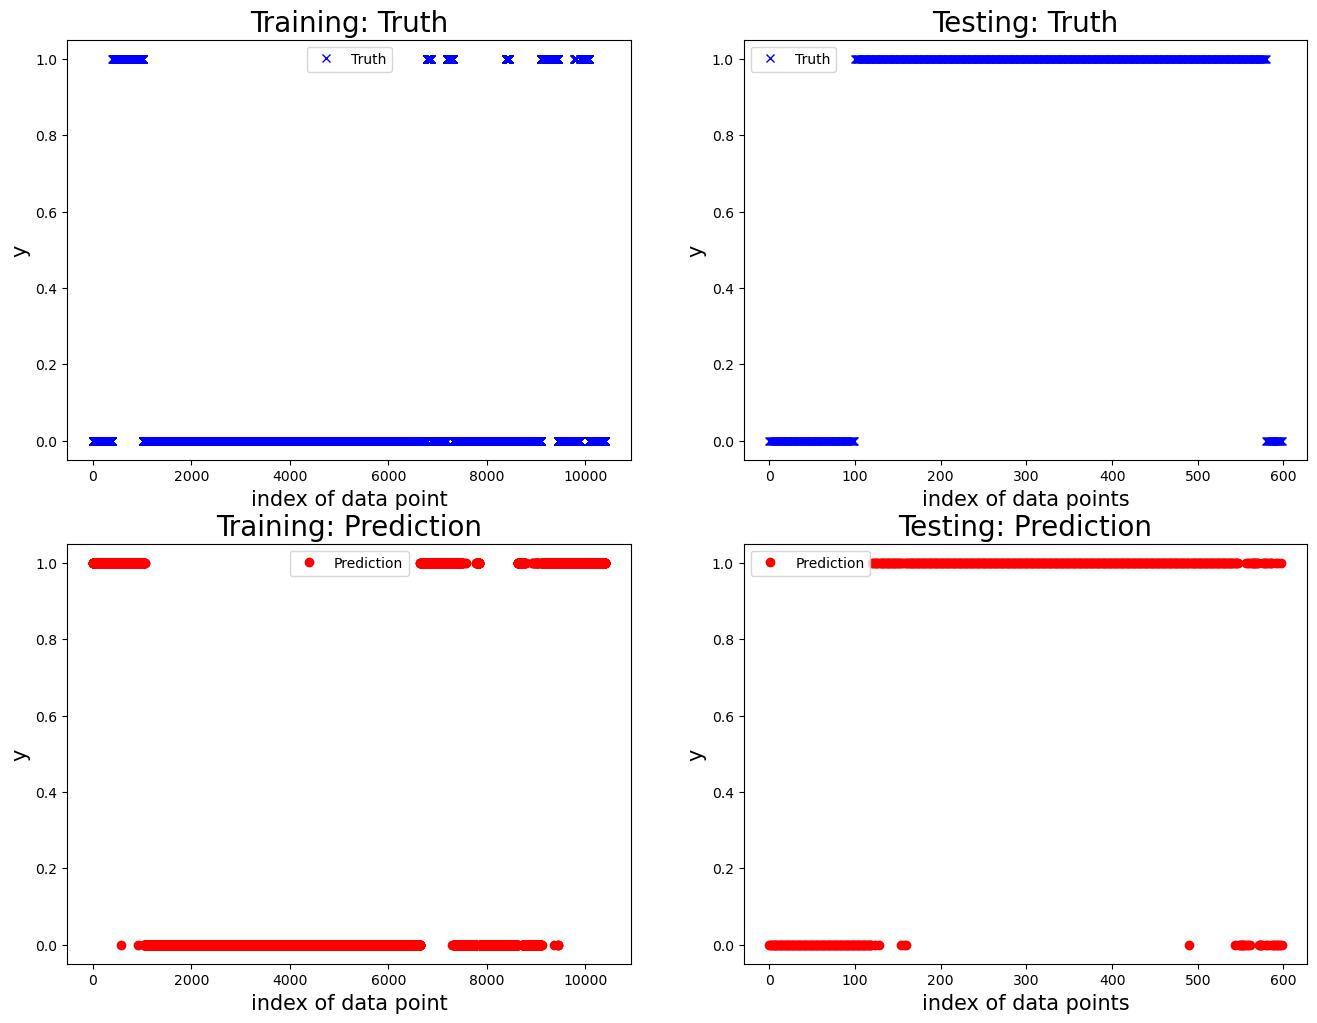


 New cv run:

Training performance, accuracy is: 0.8073277967757694
Training performance, precision is: 0.46089385474860334
Training performance, recall: 0.8633720930232558
Training performance, F1: 0.6009712666936463


Prediction performance, accuracy is: 0.2728442728442728
Prediction performance, precision is: 0.2728442728442728
Prediction performance, recall is：1.0
Prediction performance, F1 is：0.4287158746208291


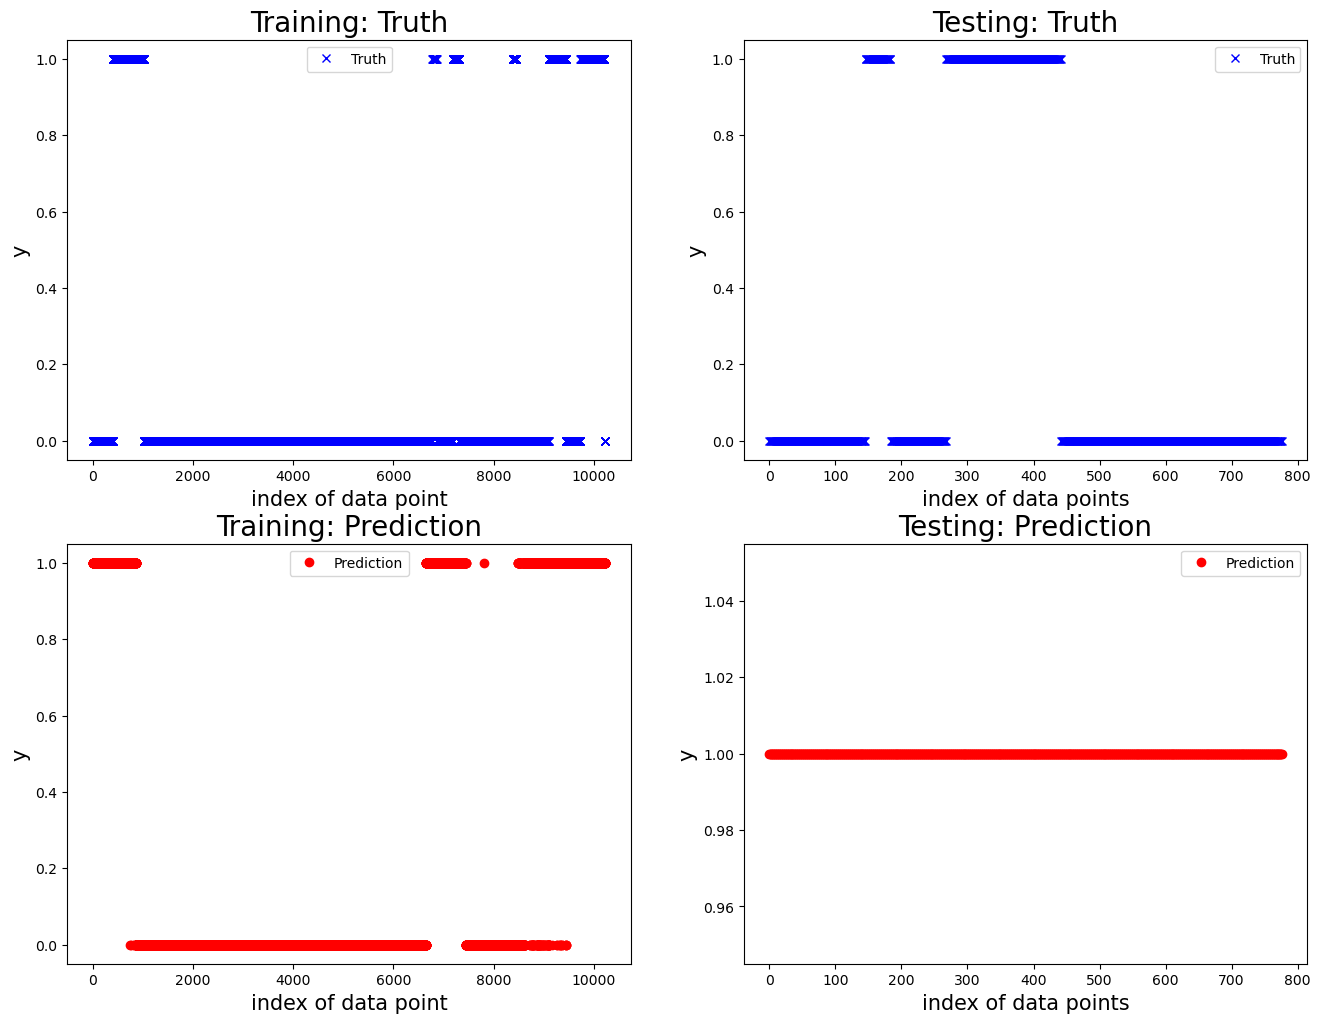

   Accuracy  Precision    Recall  F1 score
0  0.223594   0.014026  0.095578  0.024461
1  0.784289   0.000000  0.000000  0.000000
2  0.592689   0.000000  0.000000  0.000000
3  0.914858   0.982022  0.910417  0.944865
4  0.272844   0.272844  1.000000  0.428716


Mean performance metric and standard error:
Accuracy: 0.5577 +- 0.3053
Precision: 0.2538 +- 0.4234
Recall: 0.4012 +- 0.5082
F1 score: 0.2796 +- 0.4142




In [9]:
from utility import run_cv_one_motor

# Specify the test conditions you would like to include in the test.
df_data_test = df_data[df_data['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055',
                                                       '20240503_164675', '20240503_165189',
                                                       '20240503_163963', '20240325_155003'])]
# We want a five-fold cross validation.
n_cv = 5
# Define the features.
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']
all_result = run_cv_one_motor(motor_idx=6, df_data=df_data_test, mdl=grid_search, feature_list=feature_list_all, n_fold=n_cv)


For each run in the cross validation, the function shows the performance on the training and testing dataset. This can be used for diagnosis and improving the model performance. In the end, the mean performance is printed. 

If you set the parameter `single_run_result=False`, only the final average performance is printed.

# Seperate operation mode

In this section, we seperate the three operation modes, and train a specific model per operation mode. For each operation mode, we further compare:
- Select all the features V.S. select only the positions and the temperature of the current motor.
- window_size=0: only use current measurement V.S. window_size=5: use five previous points together as features.

## Not moving

In [10]:
from utility import run_cv_one_motor


# Define a function to run experiment.
def run_experiment(motor_id, df_data, mdl, window_size, n_fold):
    print(f'window_size={window_size}, all the features.')
    feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']
    _ = run_cv_one_motor(motor_id, df_data, mdl, feature_list_all, n_fold=n_fold, window_size=window_size, single_run_result=False, mdl_type='clf')

    print(f'window_size={window_size}, randomly pick features.')
    feature_list_self = ['time', 'data_motor_6_position', 'data_motor_6_temperature', 
                        'data_motor_5_position', 'data_motor_4_position', 'data_motor_3_position', 'data_motor_2_position', 'data_motor_1_position']
    _ = run_cv_one_motor(motor_id, df_data, mdl, feature_list_self, n_fold=n_fold, window_size=window_size, single_run_result=False, mdl_type='clf')

In [11]:
# Not moving
df_data_mode = df_data[df_data['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055'])]
n_cv = 3

# Windowsize = 0.
window_size = 0
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, n_fold=n_cv)

# Windowsize = 5.
window_size = 5
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, n_fold=n_cv)

window_size=0, all the features.
Model for predicting the label of motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.935065   0.876404  0.951220  0.912281
1  0.723214   0.453571  0.984496  0.621027
2  0.965517   0.775510  0.603175  0.678571


Mean performance metric and standard error:
Accuracy: 0.8746 +- 0.1320
Precision: 0.7018 +- 0.2208
Recall: 0.8463 +- 0.2112
F1 score: 0.7373 +- 0.1543


window_size=0, randomly pick features.
Model for predicting the label of motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.961039   1.000000  0.890244  0.941935
1  0.551786   0.339474  1.000000  0.506876
2  0.060345   0.060345  1.000000  0.113821


Mean performance metric and standard error:
Accuracy: 0.5244 +- 0.4510
Precision: 0.4666 +- 0.4826
Recall: 0.9634 +- 0.0634
F1 score: 0.5209 +- 0.4142


window_size=5, all the features.
Model for predicting the label of motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.933628   0.876404  0.951220  0.912281
1  0.720721   0.453571  0.

## Move only motor 6.

In [12]:
# Turning motor 6
df_data_mode = df_data[df_data['test_condition'].isin(['20240503_164675', '20240503_165189'])]
n_cv = 2

# Windowsize = 0.
window_size = 0
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, n_fold=n_cv)

# Windowsize = 5.
window_size = 5
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, n_fold=n_cv)

window_size=0, all the features.
Model for predicting the label of motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.198664   0.000000  0.000000  0.000000
1  0.512227   0.011696  0.009434  0.010444


Mean performance metric and standard error:
Accuracy: 0.3554 +- 0.2217
Precision: 0.0058 +- 0.0083
Recall: 0.0047 +- 0.0067
F1 score: 0.0052 +- 0.0074


window_size=0, randomly pick features.
Model for predicting the label of motor 6:
   Accuracy  Precision   Recall  F1 score
0  0.634391   1.000000  0.54375  0.704453
1  0.272844   0.272844  1.00000  0.428716


Mean performance metric and standard error:
Accuracy: 0.4536 +- 0.2557
Precision: 0.6364 +- 0.5142
Recall: 0.7719 +- 0.3226
F1 score: 0.5666 +- 0.1950


window_size=5, all the features.
Model for predicting the label of motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.191919   0.000000  0.000000  0.000000
1  0.510363   0.017442  0.014151  0.015625


Mean performance metric and standard error:
Accuracy: 0.3511 +- 0.2252

## Pick up and place

In [13]:
# Turning motor 6
df_data_mode = df_data[df_data['test_condition'].isin(['20240503_163963', '20240325_155003'])]
n_cv = 2

# Windowsize = 0.
window_size = 0
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, n_fold=n_cv)

# Windowsize = 5.
window_size = 5
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, n_fold=n_cv)

window_size=0, all the features.
Model for predicting the label of motor 6:
   Accuracy  Precision  Recall  F1 score
0  0.093055   0.093055     1.0  0.170265
1  0.697998   0.000000     0.0  0.000000


Mean performance metric and standard error:
Accuracy: 0.3955 +- 0.4278
Precision: 0.0465 +- 0.0658
Recall: 0.5000 +- 0.7071
F1 score: 0.0851 +- 0.1204


window_size=0, randomly pick features.
Model for predicting the label of motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.093055   0.093055  1.000000  0.170265
1  0.266319   0.276173  0.881844  0.420619


Mean performance metric and standard error:
Accuracy: 0.1797 +- 0.1225
Precision: 0.1846 +- 0.1295
Recall: 0.9409 +- 0.0835
F1 score: 0.2954 +- 0.1770


window_size=5, all the features.
Model for predicting the label of motor 6:
   Accuracy  Precision  Recall  F1 score
0  0.093125   0.093125     1.0  0.170383
1  0.696678   0.000000     0.0  0.000000


Mean performance metric and standard error:
Accuracy: 0.3949 +- 0.4268
Precisio

# Mix operation mode

In [14]:
# Turning motor 6
df_data_mode = df_data[df_data['test_condition'].isin(['20240425_093699', '20240425_094425', '20240426_140055',
                                                       '20240503_164675', '20240503_165189',
                                                       '20240503_163963', '20240325_155003'])]
n_cv = 7

# Windowsize = 0.
window_size = 0
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, n_fold=n_cv)

# Windowsize = 5.
window_size = 5
run_experiment(motor_id=6, df_data=df_data_mode, mdl=grid_search, window_size=window_size, n_fold=n_cv)

window_size=0, all the features.
Model for predicting the label of motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.423181   0.000000  0.000000  0.000000
1  0.354978   0.354978  1.000000  0.523962
2  0.769643   0.000000  0.000000  0.000000
3  0.060345   0.060345  1.000000  0.113821
4  0.592689   0.000000  0.000000  0.000000
5  0.914858   0.982022  0.910417  0.944865
6  0.272844   0.272844  1.000000  0.428716


Mean performance metric and standard error:
Accuracy: 0.4841 +- 0.2954
Precision: 0.2386 +- 0.3582
Recall: 0.5586 +- 0.5235
F1 score: 0.2873 +- 0.3620


window_size=0, randomly pick features.
Model for predicting the label of motor 6:
   Accuracy  Precision    Recall  F1 score
0  0.345460   0.069204  0.484653  0.121114
1  0.926407   1.000000  0.792683  0.884354
2  0.769643   0.000000  0.000000  0.000000
3  0.361111   0.000000  0.000000  0.000000
4  0.527415   0.247423  0.276657  0.261224
5  0.913189   0.917969  0.979167  0.947581
6  0.272844   0.272844  1.000000  0.428716